# **Laboratório - CRC (Cyclic Redundancy Check)**
### Disciplina: Redes de Computadores
### Professor: Thiago Nobrega

---

## **Integrantes do Grupo**
- Antonio Barros de Alcantara Neto
- Everton Daniel de Lima Romualdo
- Stefano Germano Tumbiolo Canal
-

# **Sumário**
1. Parte 1 — Fundamentos
2. Parte 2 — Implementação Manual
3. Parte 3 — Comparativo de Desempenho
4. Parte 4 — Análise de Erros

---

## Parte 1 - Fundamentos

O CRC funciona porque trata a mensagem como um polinômio e divide esse polinômio por outro especialmente escolhido, o gerador. A divisão é módulo 2 (XOR), que é simples e eficiente. O resto dessa divisão detecta alterações estruturais nos bits. Somente erros cujo polinômio é múltiplo exato do gerador passam despercebidos — algo extremamente improvável quando G(x) é bem escolhido.


1. `Mensagens como Polinômios:`\
Bits representam coeficientes de um polinômio em GF(2).\
Ex.: 1101 -> X<sup>3</sup> + X<sup>2</sup> + 1



2. `Divisão módulo 2 (XOR):`\
A divisão usada no CRC é feita em aritmética módulo 2, onde XOR é a soma. Não existe carry. É simples e rápida de implementar em hardware ou software.

3. `Por que anexar zeros?`\
Adicionar r zeros (ou multiplocar por 2<sup>r</sup>) só desloca a mensagem para deixar espaço para o CRC que será calculado pelo resto da divisão.

4. `O papel do gerador:`\
O polinômio gerador G(x) é escolhido para detectar:

    - todos os erros de 1 bit
    - todos os erros de 2 bits
    - rajadas de erro até r bits
    - e ter probabilidade mínima de falha em erros maiores

    Um erro só passa se o polinômio de erro for múltiplo exato de G(x), o que é muito raro com geradores bem escolhidos.

5. `Verificação:`\
O receptor divide novamente por G(x):
    - resto = 0 -> mensagem válida
    - resto &ne; 1 -> erro detectado.

## Parte 2 - Implementação Manual

#### XOR


In [1]:
def xor_bits(a, b):
    """
    Realiza a operação de XOR bit a bit entre duas strings binárias de mesmo comprimento.
    """
    resultado = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            resultado += '0'
        else:
            resultado += '1'
    return resultado

### Calculo do CRC de forma manual

In [2]:
def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    """
    Calcula o CRC para uma sequência de dados M(x) usando um gerador G(x).

    Args:
        dados_bits: A string binária representando o polinômio da mensagem, M(x).
        gerador_bits: A string binária representando o polinômio gerador, G(x).

    Returns:
        A string binária de r bits representando o CRC.
    """
    # 1. Obtenha o grau 'r' do gerador.
    #    Lembre-se que um gerador de n bits representa um polinômio de grau n-1.
    r = len(gerador_bits) - 1

    # 2. Crie T(x)=  M(x) * 2^r, que é a mensagem com 'r' zeros anexados.
    mensagem_aumentada = list(dados_bits + '0' * r)

    # 3. Implemente o loop de divisão.
    #    Percorra os bit original da mensagem (em uma janela), da esquerda para a direita.
    for i in range(len(dados_bits)):
        # Se o bit mais significativo da 'janela' atual for '1', realize o XOR.
        # - considere a janela atual como os próximos r+1 bits. (para pode dividir o por G(x))
        if mensagem_aumentada[i] == '1':
            inicio = i
            fim = i + len(gerador_bits)

            janela_atual = "".join(mensagem_aumentada[inicio : fim])  # inicio e fim devem calculados
            resultado_xor = xor_bits(janela_atual, gerador_bits)

            # Atualize a mensagem com o resultado do XOR.
            # - Substitua os bits correspondentes na mensagem pela saída do XOR,
#          ignorando o primeiro bit (que já foi processado).
            for j in range(len(resultado_xor)):
                #@author: Everton
                #Esse "+1" pode ser problematico, alguns caso de teste ele estoura a list
                mensagem_aumentada[i + j + 1] = resultado_xor[j]

    # 4. O resto da divisão são os 'r' bits finais da mensagem processada.
    resto = "".join(mensagem_aumentada[-r:])
    return resto

### Executanto testes para validação do algoritmo

Com o objetivo de mostrar que a execução da formula feita está funcionando como deveria criamos alguns testes para realizar essa validação

In [3]:
# Exemplo de uso para validação
dados_teste = "1101011111"  # M(x)
gerador_teste = "10011"    # G(x)
crc_calculado = calcular_crc_manual(dados_teste, gerador_teste)

#dados do slide RCNA05:
#Dados: 1101011111
#Gerador: 10011
#CRC: 0010
#INCOSISTÊNCIA!
print(f"Dados M(x): {dados_teste}")
print(f"Gerador G(x): {gerador_teste}")
print(f"CRC Calculado: {crc_calculado}")
# Quadro T(x) a ser transmitido: dados_teste + crc_calculado
print(f"Quadro trasmitido: {dados_teste + crc_calculado}")


Dados M(x): 1101011111
Gerador G(x): 10011
CRC Calculado: 1011
Quadro trasmitido: 11010111111011


#### Inconsistência nos resultados

Os dados do slide e do teste executado são os mesmo. Porem os CRCs calculados divergem. Não encontrei erros os bugs na implementação do algoritmo e validei que os dados são os mesmos.

#### Pontos de atenção no algoritmo
A substitição dos bits em "mensagem_aumentada[i + j + 1] = resultado_xor[j]" é uma otimização. Em alguns casos de testes aleatorios que executei resultavam em um estouro de indice. Na minha análise era causado porque o gerador que testei começa com bit "0" causando o estouro porque compremetia a integridade da divisão que era feito antes. É válido lembrar que o gerador deve ter tamanho maior que 2 e começar com bit "1" senão o grau dele sera compremetido. Alem disso é bom que termine em "1", caso contrario, o CRC pode "ficar cego" para alguns erros impossibilitando recuperação de dados.


<a id='parte3'></a>

# Parte 3 - Comparativo de desempenho

Será realizado uma  analise de desempenho da  implementação manual do CRC e comparar com a implementação otimizada da biblioteca `crc`.

O objetivo é medir dois fatores importantes:

-  **Tempo de execução:** Quanto tempo cada implementação leva para calcular o CRC.
-  **Pico de memória:** Quanta memória cada abordagem utiliza durante a execução.

#### Instalação das bibliotécas que vão ser usadas.

In [4]:
%pip install crc matplotlib pandas

Note: you may need to restart the kernel to use updated packages.



As bibliotecas abaixo serão utilizadas para medir o desempenho do cálculo de CRC, incluindo
tempo de execução, uso de memória e manipulação de arquivos.

- **time** – mede o tempo gasto na execução das funções.
- **tracemalloc** – monitora o uso e o pico de memória.
- **os** – permite manipular caminhos e arquivos do sistema.
- **crc (Calculator, Crc16)** – biblioteca externa usada para validar o CRC gerado pela implementação manual.


In [5]:
import time
import tracemalloc
import os
from crc import Calculator, Crc16

### Calculo manual do CRC:
Abaixo, foi implementada a lógica matemática do CRC sem o uso de bibliotecas externas. O objetivo deste trecho é demonstrar o funcionamento interno do algoritmo e para que em seguida seja realizada a comparação de performace com as bibliotecas padrões.

In [6]:
def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    r = len(gerador_bits) - 1
    mensagem_aumentada = list(dados_bits + '0' * r)

    for i in range(len(dados_bits)):
        if mensagem_aumentada[i] == '1':
            inicio = i
            fim = i + len(gerador_bits)
            janela = "".join(mensagem_aumentada[inicio:fim])

            resultado_xor = xor_bits(janela, gerador_bits)

            for j in range(len(resultado_xor)):
                mensagem_aumentada[i + j] = resultado_xor[j]

    resto = "".join(mensagem_aumentada[-r:])
    return resto


O código a seguir mede o tempo e o pico de memória usados para calcular o CRC de mensagens de diferentes tamanhos.
Para cada tamanho de mensagem, o código:

1. Gera dados aleatórios.
2. Calcula o CRC manualmente.
3. Calcula o CRC usando a biblioteca.
4. Mede tempo e memória de cada método.
5. Armazena os resultados para análise.

In [7]:
calculator_lib = Calculator(Crc16.MODBUS)

tamanhos_bytes = [1500, 3000, 6000, 16000]
resultados = []

for tamanho in tamanhos_bytes:
    print(f"Analisando mensagem de {tamanho} bytes...")

    mensagem_bytes = os.urandom(tamanho)
    mensagem_bits = "".join(format(byte, '08b') for byte in mensagem_bytes)

    tracemalloc.start()
    inicio = time.perf_counter()

    crc_manual = calcular_crc_manual(mensagem_bits, "11000000000000101")

    fim = time.perf_counter()
    mem_atual_manual, mem_pico_manual = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempo_manual = fim - inicio

    tracemalloc.start()
    inicio = time.perf_counter()

    crc_lib = calculator_lib.checksum(mensagem_bytes)

    fim = time.perf_counter()
    mem_atual_lib, mem_pico_lib = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempo_lib = fim - inicio

    resultados.append({
        "tamanho": tamanho,
        "tempo_manual": tempo_manual,
        "mem_pico_manual": mem_pico_manual / 1024,
        "tempo_lib": tempo_lib,
        "mem_pico_lib": mem_pico_lib / 1024
    })

resultados

Analisando mensagem de 1500 bytes...
Analisando mensagem de 3000 bytes...
Analisando mensagem de 6000 bytes...
Analisando mensagem de 16000 bytes...


[{'tamanho': 1500,
  'tempo_manual': 0.14356482300001971,
  'mem_pico_manual': 105.7509765625,
  'tempo_lib': 0.045815210999990086,
  'mem_pico_lib': 1.765625},
 {'tamanho': 3000,
  'tempo_manual': 0.26551399299989953,
  'mem_pico_manual': 211.2197265625,
  'tempo_lib': 0.08465846299998248,
  'mem_pico_lib': 1.21875},
 {'tamanho': 6000,
  'tempo_manual': 0.5189981839999973,
  'mem_pico_manual': 422.1572265625,
  'tempo_lib': 0.1664552070000127,
  'mem_pico_lib': 1.21875},
 {'tamanho': 16000,
  'tempo_manual': 1.3761579099999608,
  'mem_pico_manual': 1125.2822265625,
  'tempo_lib': 0.459963241999958,
  'mem_pico_lib': 1.21875}]

#### Geração dos gráficos

Após coletarmos os tempos de execução e o pico de memória utilizados por cada abordagem
(manual e biblioteca), é importante visualizar esses dados de forma clara.
Os gráficos abaixo servem exatamente para isso: permitir uma comparação direta entre o
desempenho das duas implementações conforme o tamanho da mensagem aumenta.

O primeiro gráfico mostra como o **tempo de cálculo do CRC** cresce à medida que as mensagens
ficam maiores. Assim, conseguimos identificar facilmente qual método escala melhor.

O segundo gráfico apresenta o **uso de memória**, permitindo observar se alguma implementação
demanda mais recursos conforme o processamento aumenta.

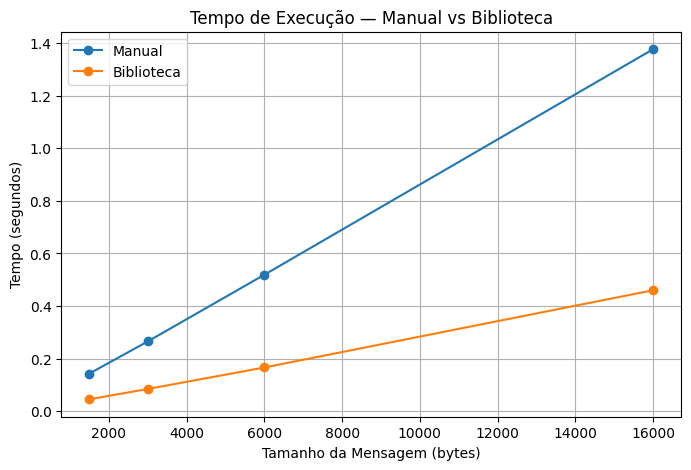

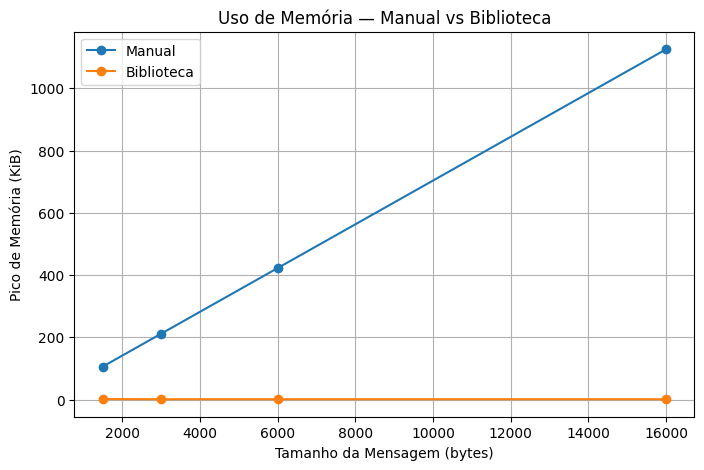

In [8]:
import matplotlib.pyplot as plt

tamanhos = [r["tamanho"] for r in resultados]

tempos_manual = [r["tempo_manual"] for r in resultados]
tempos_lib = [r["tempo_lib"] for r in resultados]

mem_manual = [r["mem_pico_manual"] for r in resultados]
mem_lib = [r["mem_pico_lib"] for r in resultados]

# Gráfico 1 — tempo
plt.figure(figsize=(8,5))
plt.plot(tamanhos, tempos_manual, marker='o', label="Manual")
plt.plot(tamanhos, tempos_lib, marker='o', label="Biblioteca")
plt.xlabel("Tamanho da Mensagem (bytes)")
plt.ylabel("Tempo (segundos)")
plt.title("Tempo de Execução — Manual vs Biblioteca")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 2 — memória
plt.figure(figsize=(8,5))
plt.plot(tamanhos, mem_manual, marker='o', label="Manual")
plt.plot(tamanhos, mem_lib, marker='o', label="Biblioteca")
plt.xlabel("Tamanho da Mensagem (bytes)")
plt.ylabel("Pico de Memória (KiB)")
plt.title("Uso de Memória — Manual vs Biblioteca")
plt.legend()
plt.grid(True)
plt.show()

<a id='parte4'></a>

# Parte 4 - Analise de Erros


Antes de podermos fazer a análise é preciso que  o ambiente esteja configurado para essa execução, para isso foi criado esse código abaixo que vai possibilitar a criação de uma bateria de testes aos quais usaremos para mostrar a robustez do CRC.

In [9]:
import random
import pandas as pd
from IPython.display import display # Garante a exibição bonita no Jupyter/Colab

Abaixo, está o código responsavel pela criação do ambiuente que vai possibilitar a execução da bateriade testes grantes  o suficiente para o algoritmo de CRC ter alguma possibilidade de falhar.

In [10]:
def get_gerador(final_matricula: int):
    """
    Retorna o gerador equivalente ao final da matricula

    Args:
          final_matricula: o final matricula

    Returns:
        Uma string que é o gerador CRC
    """

    #Geradores disponibilizados no README
    GERADOR_CRC_1_2_3_MODBUS = "11000000000000101"
    #esse ARC tem 17 bits segundo README, em caso de problemas use MODBUS
    GERADOR_CRC_3_4_5_ARC = "1100000100010001"
    GERADOR_CRC_6_7_MAXIM = "10011000000010001"
    GERADOR_CRC_8_9_CCITT_FALSE = "10001000000100001"

    match final_matricula:
        case 1 | 2:
            return GERADOR_CRC_1_2_3_MODBUS
        case 3 | 4 | 5:
            return GERADOR_CRC_3_4_5_ARC
        case 6 | 7:
            return GERADOR_CRC_6_7_MAXIM
        case 8 | 9:
            return GERADOR_CRC_8_9_CCITT_FALSE
        case _:
            return "Identificador inválido. Use 1, 2, 3, 4, 5, 6, 7, 8 ou 9 que é o seu final de matricula"

def injetar_erro_rajada(quadro_bits, tamanho_rajada):
    """
    Injeta uma rajada de erros (inverte bits) em uma posição aleatória.
    Retorna: (quadro_corrompido, posicao_inicio, padrao_erro)

    Everton: Eu queria gerar aleatorio para dinamizar o teste mas seria muito
    melhor indicar exatamente onde esta o erro porque até agora não houve uma falha
    sequer nos testes que fiz.

    """
    lista_bits = list(quadro_bits)
    n_bits = len(lista_bits)

    # Escolhe posição aleatória garantindo que a rajada caiba no quadro
    posicao = random.randint(0, n_bits - tamanho_rajada)

    padrao_erro = ""

    # Aplica a rajada
    for i in range(tamanho_rajada):
        bit_original = lista_bits[posicao + i]
        novo_bit = '1' if bit_original == '0' else '0'
        lista_bits[posicao + i] = novo_bit
        padrao_erro += "1" #Marcamos 1 onde houve inversão para log

    return "".join(lista_bits), posicao, tamanho_rajada

def bits_para_bytes(bits):
    """Converte string de bits para objeto bytes (para a biblioteca CRC)."""

    while len(bits) % 8 != 0:
        bits = '0' + bits
    return int(bits, 2).to_bytes(len(bits) // 8, byteorder='big')


#PARTE É CODIGO DE IA REVISÃO NECESSARIA(não retire esse comentario)
def executar_teste(mensagem_bits, final_matricula, tamanho_rajada):
    """
    Executa um teste completo de injeção e detecção de erro.
    """


    gerador = get_gerador(final_matricula)

    #Geração do Quadro Válido
    crc_original = calcular_crc_manual(mensagem_bits, gerador)
    quadro_transmitido = mensagem_bits + crc_original

    quadro_corrompido, posicao_erro, padrao_erro = injetar_erro_rajada(quadro_transmitido, tamanho_rajada)

    resto_manual = calcular_crc_manual(quadro_corrompido, gerador)

    detectou_manual = "SIM" if '1' in resto_manual else "NÃO (FALHA)"

    # Verificação com Biblioteca
    # Usa o CRC-16 MODBUS
    try:
        calc_lib = Calculator(Crc16.MODBUS)
        bytes_corrompidos = bits_para_bytes(quadro_corrompido)

        # A biblioteca calcula o checksum sobre os bytes.
        # Se o resultado for diferente de 0 (ou do esperado), ela detectou o erro.
        # Para simplificar: se check != 0, assumimos detecção.
        check_lib = calc_lib.checksum(bytes_corrompidos)
        detectou_lib = "SIM" if check_lib != 0 else "NÃO"

    except Exception as e:
        detectou_lib = f"ERRO LIB"

    # Relatório do teste
    relatorio = {
        "gerador_usado": gerador,
        "tamanho_mensagem_bits": len(mensagem_bits),
        "tamanho_quadro_total": len(quadro_transmitido),
        "posicao_erro": posicao_erro,
        "tamanho_rajada": tamanho_rajada,
        "padrao_erro_visual": padrao_erro,
        "resto_divisao_manual": resto_manual,
        "detectado_manual": detectou_manual,
        "detectado_biblioteca": detectou_lib,
        "status": "SUCESSO" if detectou_manual == "SIM" else "FALHA DE DETECÇÃO"
    }

    return relatorio

def executar_bateria_testes(mensagem_bits, final_matricula, total_testes=10):
    """
    Executa n testes de CRC com rajadas aleatórias e retorna um DataFrame pandas com os resultados.
    """
    print(f"--- Iniciando Bateria de {total_testes} Testes (Matrícula final {final_matricula}) ---")
    print(f"Mensagem Base: {mensagem_bits} [Total: {len(mensagem_bits)} bits]\n")

    dados_testes = []

    for i in range(1, total_testes + 1):

        tamanho_rajada = random.randint(1, 20)
        resultado = executar_teste(mensagem_bits, final_matricula, tamanho_rajada)

        dados_testes.append({
            "ID": i,
            "Posição": resultado["posicao_erro"],
            "Tamanho da Rajada": tamanho_rajada,
            "Manual": resultado["detectado_manual"],
            "Lib": resultado["detectado_biblioteca"],
            "Padrão Erro": resultado["padrao_erro_visual"]
        })

    # Cria o DataFrame
    df = pd.DataFrame(dados_testes)

    # Exibe a tabela principal
    print(">>> Tabela Detalhada dos Testes:")
    display(df)

    # --- Cálculo e Exibição do Resumo Estatístico ---
    sucessos_manual = df[df["Manual"] == "SIM"].shape[0]
    sucessos_lib = df[df["Lib"] == "SIM"].shape[0]

    taxa_manual = (sucessos_manual / total_testes) * 100
    taxa_lib = (sucessos_lib / total_testes) * 100

    print("\n" + "="*40)
    print("RESUMO ESTATÍSTICO")
    print("="*40)
    print(f"Total de Testes: {total_testes}")
    print(f"Manual: {sucessos_manual} detectados ({taxa_manual:.1f}%)")
    print(f"Lib:    {sucessos_lib} detectados ({taxa_lib:.1f}%)")
    print("="*40)

    return df


### Realização de testes no algoritmo CRC

Para demonstrar a robustez do algoritmo CRC contra falhas de integridade  realizamos uma bateria de testes automatizados. A validação foi feita de forma escalonada, inicamos com 10 execuções e fomos progredindo para 100, 500, 1.0000, 10.000, e, finalmente, 100.000 iterações por cenário.


In [11]:
#Constantes para bateria de testes
MENSAGEM_EVERTON = "Everton Daniel de Lima Romualdo"
MENSAGEM_BASE_EVERTON = "01000101011101100110010101110010011101000110111101101110001000000100010001100001011011100110100101100101011011000010000001100100011001010010000001001100011010010110110101100001001000000101001001101111011011010111010101100001011011000110010001101111"
FINAL_MATRICULA_EVERTON = 2

MENSAGEM_ANTONIO = "Antonio Barros de Alcantara Neto"
MENSAGEM_BASE_ANTONIO = "0100000101101110011101000110111101101110011010010110111100100000010000100110000101110010011100100110111101110011001000000110010001100101001000000100000101101100011000110110000101101110011101000110000101110010011000010010000001001110011001010111010001101111"
FINAL_MATRICULA_ANTONIO = 3

MENSAGEM_STEFANO = "Stefano Germano Tumbiolo Canal"
MENSAGEM_BASE_STEFANO = "010100110111010001100101011001100110000101101110011011110010000001000111011001010111001001101101011000010110111001101111001000000101010001110101011011010110001001101001011011110110110001101111001000000100001101100001011011100110000101101100"
FINAL_MATRICULA_STEFANO = 1

In [13]:
print(executar_bateria_testes(MENSAGEM_BASE_EVERTON, FINAL_MATRICULA_EVERTON, 10))
print(executar_bateria_testes(MENSAGEM_BASE_EVERTON, FINAL_MATRICULA_EVERTON, 500))
print(executar_bateria_testes(MENSAGEM_BASE_EVERTON, FINAL_MATRICULA_EVERTON, 1000))
print(executar_bateria_testes(MENSAGEM_BASE_EVERTON, FINAL_MATRICULA_EVERTON, 10000))
print(executar_bateria_testes(MENSAGEM_BASE_EVERTON, FINAL_MATRICULA_EVERTON, 100000))

print(executar_bateria_testes(MENSAGEM_BASE_ANTONIO, FINAL_MATRICULA_ANTONIO, 10))
print(executar_bateria_testes(MENSAGEM_BASE_ANTONIO, FINAL_MATRICULA_ANTONIO, 500))
print(executar_bateria_testes(MENSAGEM_BASE_ANTONIO, FINAL_MATRICULA_ANTONIO, 1000))
print(executar_bateria_testes(MENSAGEM_BASE_ANTONIO, FINAL_MATRICULA_ANTONIO, 10000))
print(executar_bateria_testes(MENSAGEM_BASE_ANTONIO, FINAL_MATRICULA_ANTONIO, 100000))

print(executar_bateria_testes(MENSAGEM_BASE_STEFANO, FINAL_MATRICULA_STEFANO, 10))
print(executar_bateria_testes(MENSAGEM_BASE_STEFANO, FINAL_MATRICULA_STEFANO, 500))
print(executar_bateria_testes(MENSAGEM_BASE_STEFANO, FINAL_MATRICULA_STEFANO, 1000))
print(executar_bateria_testes(MENSAGEM_BASE_STEFANO, FINAL_MATRICULA_STEFANO, 10000))
print(executar_bateria_testes(MENSAGEM_BASE_STEFANO, FINAL_MATRICULA_STEFANO, 100000))

--- Iniciando Bateria de 10 Testes (Matrícula final 2) ---
Mensagem Base: 01000101011101100110010101110010011101000110111101101110001000000100010001100001011011100110100101100101011011000010000001100100011001010010000001001100011010010110110101100001001000000101001001101111011011010111010101100001011011000110010001101111 [Total: 248 bits]

>>> Tabela Detalhada dos Testes:


,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,44,19,SIM,SIM,19
1,2,127,1,SIM,SIM,1
2,3,15,3,SIM,SIM,3
3,4,202,18,SIM,SIM,18
4,5,24,10,SIM,SIM,10
5,6,27,17,SIM,SIM,17
6,7,116,7,SIM,SIM,7
7,8,198,19,SIM,SIM,19
8,9,207,10,SIM,SIM,10
9,10,248,16,SIM,SIM,16



RESUMO ESTATÍSTICO
Total de Testes: 10
Manual: 10 detectados (100.0%)
Lib:    10 detectados (100.0%)
   ID  Posição  Tamanho da Rajada Manual  Lib  Padrão Erro
0   1       44                 19    SIM  SIM           19
1   2      127                  1    SIM  SIM            1
2   3       15                  3    SIM  SIM            3
3   4      202                 18    SIM  SIM           18
4   5       24                 10    SIM  SIM           10
5   6       27                 17    SIM  SIM           17
6   7      116                  7    SIM  SIM            7
7   8      198                 19    SIM  SIM           19
8   9      207                 10    SIM  SIM           10
9  10      248                 16    SIM  SIM           16
--- Iniciando Bateria de 500 Testes (Matrícula final 2) ---
Mensagem Base: 010001010111011001100101011100100111010001101111011011100010000001000100011000010110111001101001011001010110110000100000011001000110010100100000010011000110100101101101011000

,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,94,6,SIM,SIM,6
1,2,33,8,SIM,SIM,8
2,3,78,18,SIM,SIM,18
3,4,197,6,SIM,SIM,6
4,5,47,13,SIM,SIM,13
...,...,...,...,...,...,...
495,496,33,13,SIM,SIM,13
496,497,216,16,SIM,SIM,16
497,498,8,2,SIM,SIM,2
498,499,156,12,SIM,SIM,12



RESUMO ESTATÍSTICO
Total de Testes: 500
Manual: 500 detectados (100.0%)
Lib:    500 detectados (100.0%)
      ID  Posição  Tamanho da Rajada Manual  Lib  Padrão Erro
0      1       94                  6    SIM  SIM            6
1      2       33                  8    SIM  SIM            8
2      3       78                 18    SIM  SIM           18
3      4      197                  6    SIM  SIM            6
4      5       47                 13    SIM  SIM           13
..   ...      ...                ...    ...  ...          ...
495  496       33                 13    SIM  SIM           13
496  497      216                 16    SIM  SIM           16
497  498        8                  2    SIM  SIM            2
498  499      156                 12    SIM  SIM           12
499  500      250                  1    SIM  SIM            1

[500 rows x 6 columns]
--- Iniciando Bateria de 1000 Testes (Matrícula final 2) ---
Mensagem Base: 010001010111011001100101011100100111010001101111011

,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,239,18,SIM,SIM,18
1,2,87,9,SIM,SIM,9
2,3,193,19,SIM,SIM,19
3,4,178,20,SIM,SIM,20
4,5,23,16,SIM,SIM,16
...,...,...,...,...,...,...
995,996,245,4,SIM,SIM,4
996,997,148,3,SIM,SIM,3
997,998,143,1,SIM,SIM,1
998,999,109,13,SIM,SIM,13



RESUMO ESTATÍSTICO
Total de Testes: 1000
Manual: 1000 detectados (100.0%)
Lib:    1000 detectados (100.0%)
       ID  Posição  Tamanho da Rajada Manual  Lib  Padrão Erro
0       1      239                 18    SIM  SIM           18
1       2       87                  9    SIM  SIM            9
2       3      193                 19    SIM  SIM           19
3       4      178                 20    SIM  SIM           20
4       5       23                 16    SIM  SIM           16
..    ...      ...                ...    ...  ...          ...
995   996      245                  4    SIM  SIM            4
996   997      148                  3    SIM  SIM            3
997   998      143                  1    SIM  SIM            1
998   999      109                 13    SIM  SIM           13
999  1000      211                  3    SIM  SIM            3

[1000 rows x 6 columns]
--- Iniciando Bateria de 10000 Testes (Matrícula final 2) ---
Mensagem Base: 0100010101110110011001010111001001

,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,243,8,SIM,SIM,8
1,2,66,6,SIM,SIM,6
2,3,250,9,SIM,SIM,9
3,4,137,1,SIM,SIM,1
4,5,81,5,SIM,SIM,5
...,...,...,...,...,...,...
9995,9996,40,19,SIM,SIM,19
9996,9997,124,2,SIM,SIM,2
9997,9998,194,10,SIM,SIM,10
9998,9999,161,6,SIM,SIM,6



RESUMO ESTATÍSTICO
Total de Testes: 10000
Manual: 10000 detectados (100.0%)
Lib:    10000 detectados (100.0%)
         ID  Posição  Tamanho da Rajada Manual  Lib  Padrão Erro
0         1      243                  8    SIM  SIM            8
1         2       66                  6    SIM  SIM            6
2         3      250                  9    SIM  SIM            9
3         4      137                  1    SIM  SIM            1
4         5       81                  5    SIM  SIM            5
...     ...      ...                ...    ...  ...          ...
9995   9996       40                 19    SIM  SIM           19
9996   9997      124                  2    SIM  SIM            2
9997   9998      194                 10    SIM  SIM           10
9998   9999      161                  6    SIM  SIM            6
9999  10000       66                 20    SIM  SIM           20

[10000 rows x 6 columns]
--- Iniciando Bateria de 100000 Testes (Matrícula final 2) ---
Mensagem Base: 01000

,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,230,6,SIM,SIM,6
1,2,211,18,SIM,SIM,18
2,3,237,13,SIM,SIM,13
3,4,216,6,SIM,SIM,6
4,5,93,15,SIM,SIM,15
...,...,...,...,...,...,...
99995,99996,71,7,SIM,SIM,7
99996,99997,110,11,SIM,SIM,11
99997,99998,229,8,SIM,SIM,8
99998,99999,7,14,SIM,SIM,14



RESUMO ESTATÍSTICO
Total de Testes: 100000
Manual: 100000 detectados (100.0%)
Lib:    100000 detectados (100.0%)
           ID  Posição  Tamanho da Rajada Manual  Lib  Padrão Erro
0           1      230                  6    SIM  SIM            6
1           2      211                 18    SIM  SIM           18
2           3      237                 13    SIM  SIM           13
3           4      216                  6    SIM  SIM            6
4           5       93                 15    SIM  SIM           15
...       ...      ...                ...    ...  ...          ...
99995   99996       71                  7    SIM  SIM            7
99996   99997      110                 11    SIM  SIM           11
99997   99998      229                  8    SIM  SIM            8
99998   99999        7                 14    SIM  SIM           14
99999  100000      207                  4    SIM  SIM            4

[100000 rows x 6 columns]
--- Iniciando Bateria de 10 Testes (Matrícula final 3) 

,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,29,9,SIM,SIM,9
1,2,44,14,SIM,SIM,14
2,3,249,18,SIM,SIM,18
3,4,45,12,SIM,SIM,12
4,5,27,9,SIM,SIM,9
5,6,10,9,SIM,SIM,9
6,7,127,4,SIM,SIM,4
7,8,145,17,SIM,SIM,17
8,9,168,19,SIM,SIM,19
9,10,96,15,SIM,SIM,15



RESUMO ESTATÍSTICO
Total de Testes: 10
Manual: 10 detectados (100.0%)
Lib:    10 detectados (100.0%)
   ID  Posição  Tamanho da Rajada Manual  Lib  Padrão Erro
0   1       29                  9    SIM  SIM            9
1   2       44                 14    SIM  SIM           14
2   3      249                 18    SIM  SIM           18
3   4       45                 12    SIM  SIM           12
4   5       27                  9    SIM  SIM            9
5   6       10                  9    SIM  SIM            9
6   7      127                  4    SIM  SIM            4
7   8      145                 17    SIM  SIM           17
8   9      168                 19    SIM  SIM           19
9  10       96                 15    SIM  SIM           15
--- Iniciando Bateria de 500 Testes (Matrícula final 3) ---
Mensagem Base: 010000010110111001110100011011110110111001101001011011110010000001000010011000010111001001110010011011110111001100100000011001000110010100100000010000010110110001100011011000

,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,58,2,SIM,SIM,2
1,2,211,6,SIM,SIM,6
2,3,163,8,SIM,SIM,8
3,4,92,9,SIM,SIM,9
4,5,95,14,SIM,SIM,14
...,...,...,...,...,...,...
495,496,211,15,SIM,SIM,15
496,497,210,19,SIM,SIM,19
497,498,237,8,SIM,SIM,8
498,499,186,8,SIM,SIM,8



RESUMO ESTATÍSTICO
Total de Testes: 500
Manual: 500 detectados (100.0%)
Lib:    500 detectados (100.0%)
      ID  Posição  Tamanho da Rajada Manual  Lib  Padrão Erro
0      1       58                  2    SIM  SIM            2
1      2      211                  6    SIM  SIM            6
2      3      163                  8    SIM  SIM            8
3      4       92                  9    SIM  SIM            9
4      5       95                 14    SIM  SIM           14
..   ...      ...                ...    ...  ...          ...
495  496      211                 15    SIM  SIM           15
496  497      210                 19    SIM  SIM           19
497  498      237                  8    SIM  SIM            8
498  499      186                  8    SIM  SIM            8
499  500      173                 15    SIM  SIM           15

[500 rows x 6 columns]
--- Iniciando Bateria de 1000 Testes (Matrícula final 3) ---
Mensagem Base: 010000010110111001110100011011110110111001101001011

,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,61,12,SIM,SIM,12
1,2,50,14,SIM,SIM,14
2,3,98,18,SIM,SIM,18
3,4,88,13,SIM,SIM,13
4,5,19,17,SIM,SIM,17
...,...,...,...,...,...,...
995,996,254,14,SIM,SIM,14
996,997,236,1,SIM,SIM,1
997,998,55,10,SIM,SIM,10
998,999,193,13,SIM,SIM,13



RESUMO ESTATÍSTICO
Total de Testes: 1000
Manual: 1000 detectados (100.0%)
Lib:    1000 detectados (100.0%)
       ID  Posição  Tamanho da Rajada Manual  Lib  Padrão Erro
0       1       61                 12    SIM  SIM           12
1       2       50                 14    SIM  SIM           14
2       3       98                 18    SIM  SIM           18
3       4       88                 13    SIM  SIM           13
4       5       19                 17    SIM  SIM           17
..    ...      ...                ...    ...  ...          ...
995   996      254                 14    SIM  SIM           14
996   997      236                  1    SIM  SIM            1
997   998       55                 10    SIM  SIM           10
998   999      193                 13    SIM  SIM           13
999  1000      196                 20    SIM  SIM           20

[1000 rows x 6 columns]
--- Iniciando Bateria de 10000 Testes (Matrícula final 3) ---
Mensagem Base: 0100000101101110011101000110111101

,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,49,11,SIM,SIM,11
1,2,129,1,SIM,SIM,1
2,3,67,2,SIM,SIM,2
3,4,207,6,SIM,SIM,6
4,5,230,9,SIM,SIM,9
...,...,...,...,...,...,...
9995,9996,13,8,SIM,SIM,8
9996,9997,148,15,SIM,SIM,15
9997,9998,64,8,SIM,SIM,8
9998,9999,25,5,SIM,SIM,5



RESUMO ESTATÍSTICO
Total de Testes: 10000
Manual: 10000 detectados (100.0%)
Lib:    10000 detectados (100.0%)
         ID  Posição  Tamanho da Rajada Manual  Lib  Padrão Erro
0         1       49                 11    SIM  SIM           11
1         2      129                  1    SIM  SIM            1
2         3       67                  2    SIM  SIM            2
3         4      207                  6    SIM  SIM            6
4         5      230                  9    SIM  SIM            9
...     ...      ...                ...    ...  ...          ...
9995   9996       13                  8    SIM  SIM            8
9996   9997      148                 15    SIM  SIM           15
9997   9998       64                  8    SIM  SIM            8
9998   9999       25                  5    SIM  SIM            5
9999  10000      188                  7    SIM  SIM            7

[10000 rows x 6 columns]
--- Iniciando Bateria de 100000 Testes (Matrícula final 3) ---
Mensagem Base: 01000

,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,159,18,SIM,SIM,18
1,2,99,3,SIM,SIM,3
2,3,244,11,SIM,SIM,11
3,4,193,18,SIM,SIM,18
4,5,184,4,SIM,SIM,4
...,...,...,...,...,...,...
99995,99996,20,19,SIM,SIM,19
99996,99997,10,1,SIM,SIM,1
99997,99998,213,10,SIM,SIM,10
99998,99999,234,19,SIM,SIM,19



RESUMO ESTATÍSTICO
Total de Testes: 100000
Manual: 100000 detectados (100.0%)
Lib:    100000 detectados (100.0%)
           ID  Posição  Tamanho da Rajada Manual  Lib  Padrão Erro
0           1      159                 18    SIM  SIM           18
1           2       99                  3    SIM  SIM            3
2           3      244                 11    SIM  SIM           11
3           4      193                 18    SIM  SIM           18
4           5      184                  4    SIM  SIM            4
...       ...      ...                ...    ...  ...          ...
99995   99996       20                 19    SIM  SIM           19
99996   99997       10                  1    SIM  SIM            1
99997   99998      213                 10    SIM  SIM           10
99998   99999      234                 19    SIM  SIM           19
99999  100000      160                 20    SIM  SIM           20

[100000 rows x 6 columns]
--- Iniciando Bateria de 10 Testes (Matrícula final 1) 

,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,47,4,SIM,SIM,4
1,2,50,20,SIM,SIM,20
2,3,10,17,SIM,SIM,17
3,4,221,12,SIM,SIM,12
4,5,246,2,SIM,SIM,2
5,6,171,8,SIM,SIM,8
6,7,70,6,SIM,SIM,6
7,8,91,15,SIM,SIM,15
8,9,119,7,SIM,SIM,7
9,10,215,9,SIM,SIM,9



RESUMO ESTATÍSTICO
Total de Testes: 10
Manual: 10 detectados (100.0%)
Lib:    10 detectados (100.0%)
   ID  Posição  Tamanho da Rajada Manual  Lib  Padrão Erro
0   1       47                  4    SIM  SIM            4
1   2       50                 20    SIM  SIM           20
2   3       10                 17    SIM  SIM           17
3   4      221                 12    SIM  SIM           12
4   5      246                  2    SIM  SIM            2
5   6      171                  8    SIM  SIM            8
6   7       70                  6    SIM  SIM            6
7   8       91                 15    SIM  SIM           15
8   9      119                  7    SIM  SIM            7
9  10      215                  9    SIM  SIM            9
--- Iniciando Bateria de 500 Testes (Matrícula final 1) ---
Mensagem Base: 010100110111010001100101011001100110000101101110011011110010000001000111011001010111001001101101011000010110111001101111001000000101010001110101011011010110001001101001011011

,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,213,9,SIM,SIM,9
1,2,165,5,SIM,SIM,5
2,3,4,10,SIM,SIM,10
3,4,151,5,SIM,SIM,5
4,5,174,13,SIM,SIM,13
...,...,...,...,...,...,...
495,496,217,1,SIM,SIM,1
496,497,0,12,SIM,SIM,12
497,498,219,15,SIM,SIM,15
498,499,60,4,SIM,SIM,4



RESUMO ESTATÍSTICO
Total de Testes: 500
Manual: 500 detectados (100.0%)
Lib:    500 detectados (100.0%)
      ID  Posição  Tamanho da Rajada Manual  Lib  Padrão Erro
0      1      213                  9    SIM  SIM            9
1      2      165                  5    SIM  SIM            5
2      3        4                 10    SIM  SIM           10
3      4      151                  5    SIM  SIM            5
4      5      174                 13    SIM  SIM           13
..   ...      ...                ...    ...  ...          ...
495  496      217                  1    SIM  SIM            1
496  497        0                 12    SIM  SIM           12
497  498      219                 15    SIM  SIM           15
498  499       60                  4    SIM  SIM            4
499  500       64                 11    SIM  SIM           11

[500 rows x 6 columns]
--- Iniciando Bateria de 1000 Testes (Matrícula final 1) ---
Mensagem Base: 010100110111010001100101011001100110000101101110011

,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,143,2,SIM,SIM,2
1,2,3,6,SIM,SIM,6
2,3,83,5,SIM,SIM,5
3,4,175,1,SIM,SIM,1
4,5,138,16,SIM,SIM,16
...,...,...,...,...,...,...
995,996,86,3,SIM,SIM,3
996,997,82,18,SIM,SIM,18
997,998,69,10,SIM,SIM,10
998,999,87,10,SIM,SIM,10



RESUMO ESTATÍSTICO
Total de Testes: 1000
Manual: 1000 detectados (100.0%)
Lib:    1000 detectados (100.0%)
       ID  Posição  Tamanho da Rajada Manual  Lib  Padrão Erro
0       1      143                  2    SIM  SIM            2
1       2        3                  6    SIM  SIM            6
2       3       83                  5    SIM  SIM            5
3       4      175                  1    SIM  SIM            1
4       5      138                 16    SIM  SIM           16
..    ...      ...                ...    ...  ...          ...
995   996       86                  3    SIM  SIM            3
996   997       82                 18    SIM  SIM           18
997   998       69                 10    SIM  SIM           10
998   999       87                 10    SIM  SIM           10
999  1000       96                 11    SIM  SIM           11

[1000 rows x 6 columns]
--- Iniciando Bateria de 10000 Testes (Matrícula final 1) ---
Mensagem Base: 0101001101110100011001010110011001

,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,52,14,SIM,SIM,14
1,2,207,4,SIM,SIM,4
2,3,62,4,SIM,SIM,4
3,4,30,15,SIM,SIM,15
4,5,193,6,SIM,SIM,6
...,...,...,...,...,...,...
9995,9996,219,13,SIM,SIM,13
9996,9997,158,19,SIM,SIM,19
9997,9998,132,9,SIM,SIM,9
9998,9999,38,12,SIM,SIM,12



RESUMO ESTATÍSTICO
Total de Testes: 10000
Manual: 10000 detectados (100.0%)
Lib:    10000 detectados (100.0%)
         ID  Posição  Tamanho da Rajada Manual  Lib  Padrão Erro
0         1       52                 14    SIM  SIM           14
1         2      207                  4    SIM  SIM            4
2         3       62                  4    SIM  SIM            4
3         4       30                 15    SIM  SIM           15
4         5      193                  6    SIM  SIM            6
...     ...      ...                ...    ...  ...          ...
9995   9996      219                 13    SIM  SIM           13
9996   9997      158                 19    SIM  SIM           19
9997   9998      132                  9    SIM  SIM            9
9998   9999       38                 12    SIM  SIM           12
9999  10000      170                 10    SIM  SIM           10

[10000 rows x 6 columns]
--- Iniciando Bateria de 100000 Testes (Matrícula final 1) ---
Mensagem Base: 01010

,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,190,4,SIM,SIM,4
1,2,16,9,SIM,SIM,9
2,3,145,14,SIM,SIM,14
3,4,1,16,SIM,SIM,16
4,5,137,12,SIM,SIM,12
...,...,...,...,...,...,...
99995,99996,73,13,SIM,SIM,13
99996,99997,213,3,SIM,SIM,3
99997,99998,105,17,SIM,SIM,17
99998,99999,113,16,SIM,SIM,16



RESUMO ESTATÍSTICO
Total de Testes: 100000
Manual: 100000 detectados (100.0%)
Lib:    100000 detectados (100.0%)
           ID  Posição  Tamanho da Rajada Manual  Lib  Padrão Erro
0           1      190                  4    SIM  SIM            4
1           2       16                  9    SIM  SIM            9
2           3      145                 14    SIM  SIM           14
3           4        1                 16    SIM  SIM           16
4           5      137                 12    SIM  SIM           12
...       ...      ...                ...    ...  ...          ...
99995   99996       73                 13    SIM  SIM           13
99996   99997      213                  3    SIM  SIM            3
99997   99998      105                 17    SIM  SIM           17
99998   99999      113                 16    SIM  SIM           16
99999  100000      221                  1    SIM  SIM            1

[100000 rows x 6 columns]


<a id='conclusões'></a>